In [ ]:
!git clone https://github.com/MhmdEsml/TPC.git
%cd TPC
!pip install -e .

Cloning into 'TPC'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 68 (delta 32), reused 2 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 122.86 KiB | 7.23 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/kaggle/working/TPC
Obtaining file:///kaggle/working/TPC
  Preparing metadata (setup.py) ... done
  Running setup.py develop for tpcflib


In [ ]:
!pip install porespy
!pip install pypardiso

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openpnm to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 84.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.2/303.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 38.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 96.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.5/608.5 kB 39.6 MB/s eta 0:00:00
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl si

Loading dataset...
Downloaded to: dataset/Kirby.raw
Loading 3D volume from: dataset/Kirby.raw
Computing reference bins...
Creating training data generator:
  Volume shape: (1000, 1000, 1000)
  Patch size: (128, 128, 128)
  Batch size: 8
  Compute porosity: True
  Seed: 42
Using 65 bins

Running PoreSpy (reference)...


PoreSpy:   0%|          | 0/64 [00:00<?, ?it/s]

Creating training data generator:
  Volume shape: (1000, 1000, 1000)
  Patch size: (128, 128, 128)
  Batch size: 8
  Compute porosity: True
  Seed: 42


PoreSpy: 100%|██████████| 64/64 [04:11<00:00,  3.93s/it]


PoreSpy time: 251.47s

Running JAX backend...


JAX:   0%|          | 0/64 [00:00<?, ?it/s]

Creating training data generator:
  Volume shape: (1000, 1000, 1000)
  Patch size: (128, 128, 128)
  Batch size: 8
  Compute porosity: True
  Seed: 42


JAX: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]


JAX time: 39.80s

Running PyTorch backend...


PyTorch:   0%|          | 0/64 [00:00<?, ?it/s]

Creating training data generator:
  Volume shape: (1000, 1000, 1000)
  Patch size: (128, 128, 128)
  Batch size: 8
  Compute porosity: True
  Seed: 42


PyTorch: 100%|██████████| 64/64 [00:21<00:00,  2.93it/s]


PyTorch time: 21.86s

ACCURACY COMPARISON (vs PoreSpy)
JAX   : max = 9.135e-07, mean = 7.569e-07
TORCH : max = 8.986e-07, mean = 7.534e-07

SPEEDUP vs PoreSpy
JAX   : 6.3x
TORCH : 11.5x


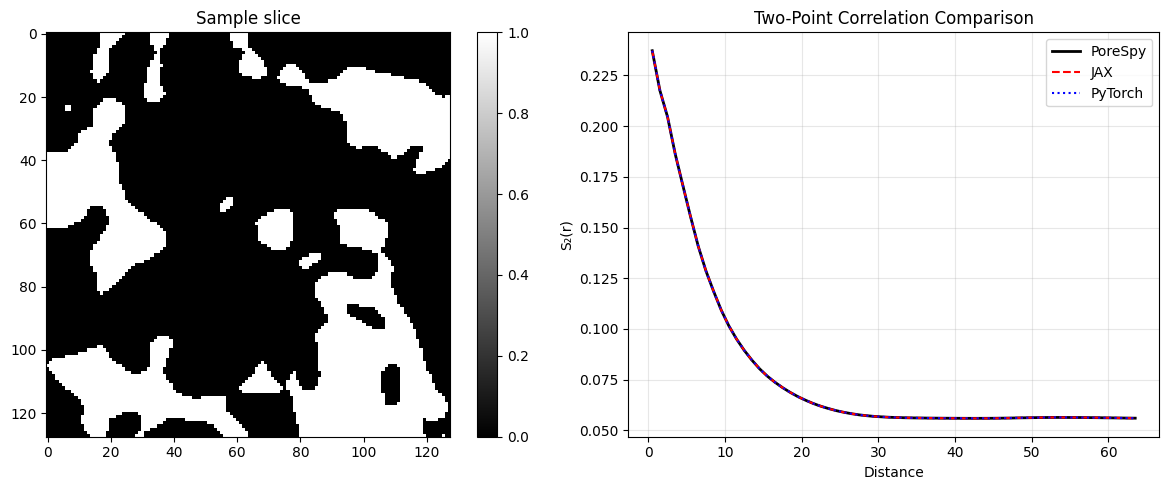

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import porespy as ps
import tpc
from tqdm import tqdm

# ==================================================
# CONFIGURATION
# ==================================================
SEED = 42
DATASET = "Kirby"
DATA_PATH = "dataset"

VOLUME_DIMS = (1000, 1000, 1000)
PATCH_SIZE = (128, 128, 128)

BATCH_SIZE = 8
N_SAMPLES = 512
N_BATCHES = N_SAMPLES // BATCH_SIZE

DEVICE = "cuda"

# ==================================================
# LOAD DATA
# ==================================================
print("Loading dataset...")

dataset_path = tpc.download_dataset(DATASET, DATA_PATH)
volume = tpc.load_volume(dataset_path, VOLUME_DIMS)
volume = 1 - volume  # pore=1, solid=0

# ==================================================
# DETERMINISTIC GENERATOR FACTORY
# ==================================================
def make_loader():
    return tpc.create_train_generator(
        volume,
        PATCH_SIZE,
        BATCH_SIZE,
        seed=SEED
    )

# ==================================================
# GET BINS (ONCE)
# ==================================================
print("Computing reference bins...")

ref_loader = make_loader()
ref_batch = next(ref_loader)
ref_img = ref_batch["images"][0, ..., 0]

ref = ps.metrics.two_point_correlation(ref_img)
BINS = ref.bin_edges

print(f"Using {len(BINS)} bins")

# ==================================================
# STORAGE (TPCFs ONLY)
# ==================================================
results = {"porespy": [], "jax": [], "torch": []}
timings = {}

# ==================================================
# PORESPY (REFERENCE)
# ==================================================
print("\nRunning PoreSpy (reference)...")

loader = make_loader()
start = time.time()

for _ in tqdm(range(N_BATCHES), desc="PoreSpy", leave=True):
    batch = next(loader)
    imgs = batch["images"][..., 0]

    for img in imgs:
        r = ps.metrics.two_point_correlation(img, bins=BINS)
        results["porespy"].append(r)

timings["porespy"] = time.time() - start
print(f"PoreSpy time: {timings['porespy']:.2f}s")

# ==================================================
# JAX BACKEND
# ==================================================
print("\nRunning JAX backend...")

loader = make_loader()
start = time.time()

for _ in tqdm(range(N_BATCHES), desc="JAX", leave=True):
    batch = next(loader)
    imgs = (batch["images"][..., 0] > 0.5).astype(np.float32)

    out = tpc.compute_tpcf(
        imgs,
        bins=BINS,
        backend="jax"
    )
    results["jax"].extend(out)

timings["jax"] = time.time() - start
print(f"JAX time: {timings['jax']:.2f}s")

# ==================================================
# PYTORCH BACKEND
# ==================================================
print("\nRunning PyTorch backend...")

loader = make_loader()
start = time.time()

for _ in tqdm(range(N_BATCHES), desc="PyTorch", leave=True):
    batch = next(loader)
    imgs = (batch["images"][..., 0] > 0.5).astype(np.float32)

    out = tpc.compute_tpcf(
        imgs,
        bins=BINS,
        backend="torch",
        device=DEVICE,
        batch_size=BATCH_SIZE
    )
    results["torch"].extend(out)

timings["torch"] = time.time() - start
print(f"PyTorch time: {timings['torch']:.2f}s")

# ==================================================
# SANITY CHECK
# ==================================================
assert len(results["porespy"]) == N_SAMPLES
assert len(results["jax"]) == N_SAMPLES
assert len(results["torch"]) == N_SAMPLES

# ==================================================
# ACCURACY COMPARISON
# ==================================================
print("\n" + "=" * 60)
print("ACCURACY COMPARISON (vs PoreSpy)")
print("=" * 60)

for method in ["jax", "torch"]:
    errors = [
        np.max(
            np.abs(
                results["porespy"][i].probability_scaled -
                results[method][i].probability_scaled
            )
        )
        for i in range(N_SAMPLES)
    ]

    print(
        f"{method.upper():6}: "
        f"max = {np.max(errors):.3e}, "
        f"mean = {np.mean(errors):.3e}"
    )

# ==================================================
# SPEEDUP
# ==================================================
print("\nSPEEDUP vs PoreSpy")
for m in ["jax", "torch"]:
    print(f"{m.upper():6}: {timings['porespy']/timings[m]:.1f}x")

# ==================================================
# PLOT ONE SAMPLE
# ==================================================
idx = 0

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(ref_img[ref_img.shape[0] // 2], cmap="gray")
plt.title("Sample slice")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(
    results["porespy"][idx].distance,
    results["porespy"][idx].probability_scaled,
    "k-", linewidth=2, label="PoreSpy"
)
plt.plot(
    results["jax"][idx].distance,
    results["jax"][idx].probability_scaled,
    "r--", label="JAX"
)
plt.plot(
    results["torch"][idx].distance,
    results["torch"][idx].probability_scaled,
    "b:", label="PyTorch"
)

plt.xlabel("Distance")
plt.ylabel("S₂(r)")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Two-Point Correlation Comparison")

plt.tight_layout()
plt.show()
